# COVID-18 Classification Project

## The Project
In the following project I will use Deep Learning techniques to classify X-Ray images of the thorax into one of three categories:
* Normal Finding
* Viral Pneumonia
* Covid-19 Pneumonia

The data used in this project is provided on [Kaggle]()

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [2]:
 #boilerplate for gpu usage from tensorflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
     # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# defining properties for images to use
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 1
EPOCHS = 1000 # set on high value to find best epoch number using early stopping
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [5]:
# create data generator for training data with augmentation
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5,
    rotation_range=90,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    vertical_flip=True
)

# creating test data generator that only performs rescaling and no augmenation
test_data_generator = ImageDataGenerator(
    rescale=1./255
)

train_iterator = train_data_generator.flow_from_directory(
    'data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)

val_iterator = test_data_generator.flow_from_directory(
    'data/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    )

test_iterator = test_data_generator.flow_from_directory(
    'data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
)

Found 253 images belonging to 3 classes.
Found 65 images belonging to 3 classes.
Found 35 images belonging to 3 classes.


In [6]:
model = tf.keras.Sequential([
    # Input layers
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    # Convolutional layers
    tf.keras.layers.Conv2D(64, (5, 5), strides=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    # flatten results to feed to DNN
    tf.keras.layers.Flatten(),
    # # hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       7

In [9]:
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=20)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)

history = model.fit(
    train_iterator,
    epochs=EPOCHS,
    validation_data=val_iterator,
    callbacks=[es]
)

Epoch 1/1000
32/32 [==============================] - 6s 110ms/step - loss: 1.1284 - categorical_accuracy: 0.3892 - auc: 0.5686 - val_loss: 1.0905 - val_categorical_accuracy: 0.4154 - val_auc: 0.5733
Epoch 2/1000
32/32 [==============================] - 2s 54ms/step - loss: 1.0926 - categorical_accuracy: 0.3597 - auc: 0.5360 - val_loss: 1.0633 - val_categorical_accuracy: 0.4154 - val_auc: 0.6542
Epoch 3/1000
32/32 [==============================] - 2s 54ms/step - loss: 1.0554 - categorical_accuracy: 0.4959 - auc: 0.6405 - val_loss: 1.0462 - val_categorical_accuracy: 0.5538 - val_auc: 0.7117
Epoch 4/1000
32/32 [==============================] - 2s 56ms/step - loss: 1.0004 - categorical_accuracy: 0.5196 - auc: 0.6969 - val_loss: 1.0176 - val_categorical_accuracy: 0.5231 - val_auc: 0.6640 categorical_accuracy: 0.5241 - auc: 
Epoch 5/1000
32/32 [==============================] - 2s 57ms/step - loss: 1.0449 - categorical_accuracy: 0.5009 - auc: 0.6429 - val_loss: 1.0589 - val_categorical_ac

32/32 [==============================] - 2s 55ms/step - loss: 0.4672 - categorical_accuracy: 0.8282 - auc: 0.9402 - val_loss: 0.4960 - val_categorical_accuracy: 0.8308 - val_auc: 0.9450
Epoch 42/1000
32/32 [==============================] - 2s 56ms/step - loss: 0.5206 - categorical_accuracy: 0.8055 - auc: 0.9265 - val_loss: 0.4098 - val_categorical_accuracy: 0.8462 - val_auc: 0.9619
Epoch 43/1000
32/32 [==============================] - 2s 56ms/step - loss: 0.6361 - categorical_accuracy: 0.7427 - auc: 0.8877 - val_loss: 0.6695 - val_categorical_accuracy: 0.6923 - val_auc: 0.8814
Epoch 44/1000
32/32 [==============================] - 2s 55ms/step - loss: 0.5286 - categorical_accuracy: 0.8064 - auc: 0.9272 - val_loss: 0.5982 - val_categorical_accuracy: 0.7385 - val_auc: 0.9031
Epoch 45/1000
32/32 [==============================] - 2s 54ms/step - loss: 0.4881 - categorical_accuracy: 0.7857 - auc: 0.9392 - val_loss: 0.3897 - val_categorical_accuracy: 0.8769 - val_auc: 0.9659
Epoch 46/1000


In [18]:
test_steps_per_epoch = numpy.math.ceil(test_iterator.samples / test_iterator.batch_size)
predictions = model.predict(test_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(test_iterator.samples / test_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = test_iterator.classes
class_labels = list(test_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   
 
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

              precision    recall  f1-score   support

       Covid       0.47      0.47      0.47        15
      Normal       0.50      0.50      0.50        10
   Pneumonia       0.30      0.30      0.30        10

    accuracy                           0.43        35
   macro avg       0.42      0.42      0.42        35
weighted avg       0.43      0.43      0.43        35

[[7 2 6]
 [4 5 1]
 [4 3 3]]


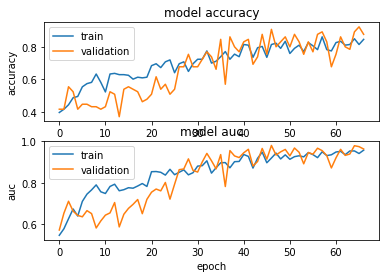

In [12]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [20]:
predictions

array([[1.3144526e-01, 2.6373711e-01, 6.0481763e-01],
       [8.9196466e-02, 7.6363742e-01, 1.4716612e-01],
       [2.3757201e-02, 2.6563872e-02, 9.4967896e-01],
       [7.9958451e-01, 1.2059752e-02, 1.8835579e-01],
       [2.7719000e-01, 2.2759248e-02, 7.0005077e-01],
       [9.8592007e-01, 6.9376733e-03, 7.1421782e-03],
       [4.7354108e-01, 2.7990004e-01, 2.4655877e-01],
       [9.3840891e-01, 1.3538144e-02, 4.8052922e-02],
       [9.9090822e-03, 7.1593493e-01, 2.7415600e-01],
       [6.0190842e-02, 1.6176642e-01, 7.7804273e-01],
       [9.4661587e-01, 1.1505470e-02, 4.1878633e-02],
       [1.4561725e-01, 1.0261294e-01, 7.5176978e-01],
       [9.9949050e-01, 5.7277251e-05, 4.5218994e-04],
       [3.5079598e-02, 6.9813810e-02, 8.9510661e-01],
       [9.9993932e-01, 1.3880047e-05, 4.6869605e-05],
       [5.3634427e-02, 8.5507429e-01, 9.1291279e-02],
       [8.0510926e-01, 1.1998189e-01, 7.4908912e-02],
       [3.8665477e-02, 7.2981763e-01, 2.3151693e-01],
       [6.0715759e-01, 2.187

In [23]:
test_iterator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [15]:
predicted_classes

array([0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 2,
       2, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0, 1, 0], dtype=int64)

In [22]:
for prediction in predictions:
    if prediction[]

0.13144526
0.089196466
0.0237572
0.7995845
0.27719
0.9859201
0.47354108
0.9384089
0.009909082
0.06019084
0.9466159
0.14561725
0.9994905
0.0350796
0.9999393
0.053634427
0.80510926
0.038665477
0.6071576
0.976138
0.20161174
0.16960369
0.9942372
0.08176566
0.020662816
0.98268855
0.00010053968
0.22431017
0.9395645
0.9965417
0.0034662425
0.027799018
0.9956182
0.0015512015
0.030926727
